In [2]:
# Descargar el archivo del dataset
!wget https://dl.fbaipublicfiles.com/clevr/CLEVR_v1.0.zip

# Descomprimir el dataset
!unzip -qq CLEVR_v1.0.zip

--2024-11-11 14:46:52--  https://dl.fbaipublicfiles.com/clevr/CLEVR_v1.0.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.244.202.62, 18.244.202.73, 18.244.202.103, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.244.202.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19021600724 (18G) [application/zip]
Saving to: ‘CLEVR_v1.0.zip’

CLEVR_v1.0.zip      100%[===================>]  17.71G   326MB/s    in 57s     

2024-11-11 14:47:49 (319 MB/s) - ‘CLEVR_v1.0.zip’ saved [19021600724/19021600724]



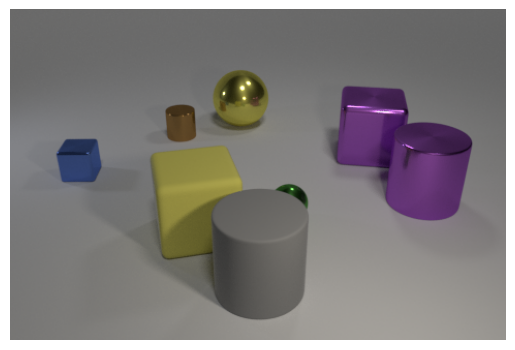

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

# Ruta a una imagen de validación
image_path = 'CLEVR_v1.0/images/val/CLEVR_val_000002.png'

# Mostrar la imagen
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
import os
import requests
from zipfile import ZipFile
from tqdm import tqdm

# Directorio base para CLEVR
base_dir = "/content/CLEVR_v1.0"
os.makedirs(base_dir, exist_ok=True)

# Rutas de destino
#questions_url = "https://cs.stanford.edu/people/jcjohns/clevr/CLEVR_v1.0/questions/CLEVR_val_questions.json"
#images_url = "https://dl.fbaipublicfiles.com/clevr/CLEVR_v1.0/images/val.zip"
val_questions_path = os.path.join(base_dir, "questions/CLEVR_val_questions.json")
val_images_path = os.path.join(base_dir, "images/val")
train_questions_path = os.path.join(base_dir, "questions/CLEVR_train_questions.json")
train_images_path = os.path.join(base_dir, "images/train")
test_questions_path = os.path.join(base_dir, "questions/CLEVR_test_questions.json")
test_images_path = os.path.join(base_dir, "images/test")


In [27]:
import json
def process_json(questions_path,base_dir,img_path, n=1000):
    # Cargar las preguntas de validación
    with open(questions_path, "r") as f:
        questions = json.load(f)

    # Crear una lista de ejemplos procesados
    data = {}
    data["images"] = []
    data["questions"] = []
    data["answers"] = []

    # Directorio de imágenes
    images_dir = os.path.join(base_dir, img_path)

    for question in tqdm(questions["questions"][:n]):  #Procesa solo n
        image_path = os.path.join(images_dir, question["image_filename"])
        if os.path.exists(image_path):
            data["images"].append(image_path)
            data["questions"].append(question["question"])
            data["answers"].append(question["answer"])
    print(f"Total de ejemplos procesados: {len(data['images'])}")
    return data

Pasa algo con la test data, no tiene answers???

In [39]:
val_data = process_json(val_questions_path,base_dir,val_images_path, n=200)
#test_data = preprocess_data(test_questions_path,base_dir,test_images_path)
train_data = process_json(train_questions_path,base_dir,train_images_path,n=1000)


100%|██████████| 200/200 [00:00<00:00, 140207.39it/s]


Total de ejemplos procesados: 200


100%|██████████| 1000/1000 [00:00<00:00, 160602.85it/s]


Total de ejemplos procesados: 1000


In [42]:
val_data['images'][5]

'/content/CLEVR_v1.0/images/val/CLEVR_val_000000.png'

# Inference with BLIP (pre-trained, no fine-tuning)

In [45]:
import torch
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering

processor = BlipProcessor.from_pretrained("ybelkada/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("ybelkada/blip-vqa-base", torch_dtype=torch.float16).to("cuda")




/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


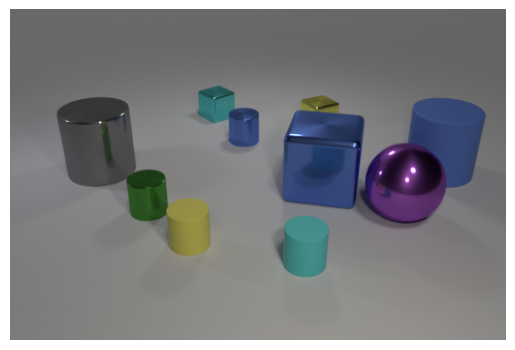

Question:  The other small shiny thing that is the same shape as the tiny yellow shiny object is what color?
Answer:  purple
Correct Answer:  cyan


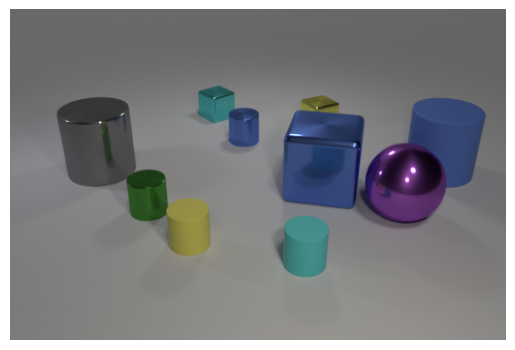

Question:  Is there anything else that has the same color as the large shiny cube?
Answer:  yes
Correct Answer:  yes


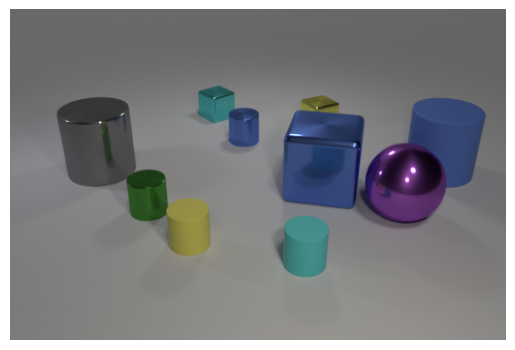

Question:  How many metallic objects are big blue cubes or blue objects?
Answer:  two
Correct Answer:  2


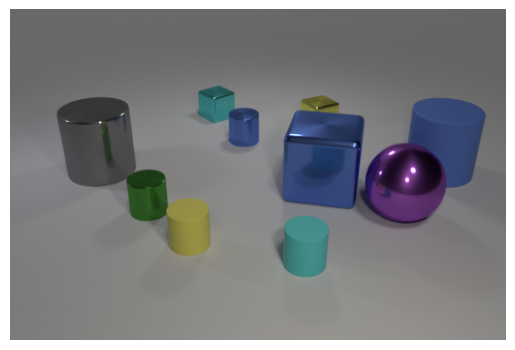

Question:  Is the color of the big matte object the same as the large metal cube?
Answer:  yes
Correct Answer:  yes


In [46]:
indices = [10,11,12,13]
for i in indices:
    raw_image = Image.open(val_data['images'][i]).convert('RGB')
    question = val_data['questions'][i]
    inputs = processor(raw_image, question, return_tensors="pt").to("cuda", torch.float16)

    out = model.generate(**inputs)

    #show image
    plt.imshow(raw_image)
    plt.axis('off')
    plt.show()
    print('Question: ', question)
    print('Answer: ', processor.decode(out[0], skip_special_tokens=True))
    print('Correct Answer: ', val_data['answers'][i])


#Serialización


In [18]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [47]:
from datasets import Dataset



train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
#test_dataset = Dataset.from_dict(test_data)


In [48]:
def preprocess_data(examples):
    images = [Image.open(image_path).convert("RGB") for image_path in examples["images"]]
    questions = examples["questions"]

    # Tokenize the inputs
    inputs = processor(images=images, text=questions, return_tensors="pt", padding=True)

    # Add labels (answers) to inputs
    inputs['labels'] = processor.tokenizer(examples["answers"], padding=True, truncation=True, return_tensors="pt").input_ids
    return inputs



In [49]:

# Apply the preprocessing function
processed_train_dataset = train_dataset.map(preprocess_data, batched=True)
processed_val_dataset = val_dataset.map(preprocess_data, batched=True)
#processed_test_dataset = test_dataset.map(preprocess_data, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [34]:
import wandb

wandb.login(key="5a7fc9085252915bf792911f84de80ea27bcfd87")


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [50]:
from transformers import TrainingArguments, Trainer

# Define training arguments
training_args = TrainingArguments(
    output_dir="./blip-vqa",
    per_device_train_batch_size=4,
    evaluation_strategy="epoch",
    num_train_epochs=3,
    save_steps=500,
    save_total_limit=2,
    logging_dir="./logs"
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_train_dataset,
    eval_dataset=processed_val_dataset,
    tokenizer=processor.tokenizer
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Start training
trainer.train()


Epoch,Training Loss,Validation Loss
1,No log,nan


Epoch,Training Loss,Validation Loss
1,No log,nan
